In [4]:
import pandas as pd
import re
import numpy as np
import os
from fuzzywuzzy import fuzz
import ast
from nltk import ngrams
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import pkg_resources
from symspellpy.symspellpy import SymSpell, Verbosity
import numpy as np
from textblob import TextBlob
import matplotlib as mpl

In [100]:
from calorieninjas import query_for_foods, query_for_food, aggregate_nutrition_component_food_dict, open_connection, nutrition_dict_to_df

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Reading food titles from subreddit (preprocessed)

In [71]:
df_food_posts = pd.read_csv(r'food_posts_preprocessed_new.csv')

In [72]:
len(df_food_posts)

561693

In [290]:
df_food_posts.head()

,Unnamed: 0,datetime,title,preprocessed_title,preprocessed_title_no_stopwords,preprocessed_title_final,ngrams_title
0,0,2018-03-01 00:01:28,[I ate] Thinly-sliced Japanese Wagyu,thinly sliced japanese wagyu,thinly sliced japanese wagyu,thinly sliced japanese wagyu,"[thinly sliced japanese wagyu, thinly sliced j..."
1,1,2018-03-01 00:13:38,"I smoked a brisket and we made doughnuts, so t...",i smoked a brisket and we made doughnuts so t...,smoked brisket doughnuts happened,smoked brisket doughnuts happened,"[smoked brisket doughnuts happened, smoked bri..."
2,2,2018-03-01 00:14:56,[I Ate] Matcha Mochi Melonpan,matcha mochi melonpan,matcha mochi melonpan,matcha mochi melonpan,"[matcha mochi melonpan, matcha mochi, mochi me..."
3,3,2018-03-01 00:15:10,[I made] this Wakanda/Black Panther inspired U...,this wakanda black panther inspired unicorn cake,wakanda black panther inspired unicorn cake,wakanda black panther inspired unicorn cake,"[wakanda black panther inspired unicorn cake, ..."
4,4,2018-03-01 00:16:01,Homemade Flax seed dough. Caper [homemade],homemade flax seed dough caper,homemade flax seed dough caper,homemade flax seed dough caper,"[homemade flax seed dough caper, homemade flax..."


### Reading nutritional information combined from usda json files (without the branded nutrition file)

In [75]:
nutritional_information_usda = pd.read_csv('nutritional_database_combined_20_05.csv')

In [76]:
nutritional_information_usda.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,description,food_class,food_category,serving_size,serving_size_unit,calories_serving_size,calories_100g,...,cholesterol_unit,carbohydrates_serving_size,carbohydrates_100g,carbohydrates_unit,fiber_serving_size,fiber_100g,fiber_unit,protein_calories,fat_calories,carb_calories
0,0,0,0,"Milk, human",Survey,Human milk,100,g,NaN,70.0,...,mg,NaN,6.89,g,NaN,0.0,g,4.12,4.473,27.56
1,1,1,0,"Milk, NFS",Survey,"Milk, reduced fat",100,g,NaN,51.0,...,mg,NaN,4.87,g,NaN,0.0,g,13.36,0.585,19.48
2,2,2,0,"Milk, whole",Survey,"Milk, whole",100,g,NaN,60.0,...,mg,NaN,4.67,g,NaN,0.0,g,13.12,0.972,18.68
3,3,3,0,"Milk, low sodium, whole",Survey,"Milk, whole",100,g,NaN,61.0,...,mg,NaN,4.46,g,NaN,0.0,g,12.40,1.152,17.84
4,4,4,0,"Milk, calcium fortified, whole",Survey,"Milk, whole",100,g,NaN,60.0,...,mg,NaN,4.67,g,NaN,0.0,g,13.12,0.972,18.68


In [81]:
nutritional_information_usda.keys()

Index(['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'description',
       'food_class', 'food_category', 'serving_size', 'serving_size_unit',
       'calories_serving_size', 'calories_100g', 'calories_unit',
       'protein_serving_size', 'protein_100g', 'protein_unit',
       'fat_serving_size', 'fat_100g', 'fat_unit', 'sugar_serving_size',
       'sugar_100g', 'sugar_unit', 'sodium_serving_size', 'sodium_100g',
       'sodium_unit', 'cholesterol_serving_size', 'cholesterol_100g',
       'cholesterol_unit', 'carbohydrates_serving_size', 'carbohydrates_100g',
       'carbohydrates_unit', 'fiber_serving_size', 'fiber_100g', 'fiber_unit',
       'protein_calories', 'fat_calories', 'carb_calories'],
      dtype='object')

In [94]:
nutritional_information_usda['fiber_unit'].value_counts()

g    14388
Name: fiber_unit, dtype: int64

### Using code from Thorsten, to get nutritional information from calorieninjas API on first 1000 entries from the food subreddit

In [218]:
conn = open_connection()
results_sample = query_for_foods(conn, df_food_posts[:6000].title) #preprocessed_title_final

Error with [I ate]Butter chicken masala, lamb curry, and garlic nan with a cabbage salad (clean: |Butter chicken masala, lamb curry, and garlic nan with a cabbage salad|)


In [219]:
nutrition_sample = aggregate_nutrition_component_food_dict(results_sample)
ninjacalories_results = nutrition_dict_to_df(nutrition_sample)
ninjacalories_results.head(10)

,food_title,calories,carbohydrates_total_g,cholesterol_mg,fat_saturated_g,fat_total_g,fiber_g,potassium_mg,protein_g,sodium_mg,sugar_g
0,Thinly-sliced Japanese Wagyu,190.7,0.000000,58.000000,5.500000,12.300000,0.000000,0.000000,20.000000,63.000000,0.000000
1,"I smoked a brisket and we made doughnuts, so t...",351.0,24.250000,68.500000,8.400000,20.550000,1.050000,144.000000,17.650000,183.500000,11.450000
2,Matcha Mochi Melonpan,132.5,26.450000,2.000000,2.250000,2.800000,0.250000,36.500000,1.350000,9.500000,18.000000
3,this Wakanda/Black Panther inspired Unicorn Cake,393.6,57.200000,74.000000,2.900000,17.600000,0.300000,142.000000,3.000000,271.000000,42.100000
4,Homemade Flax seed dough. Caper,330.2,28.333333,0.000000,4.533333,23.133333,10.700000,234.666667,7.833333,918.666667,0.666667
5,طريقة عمل عصير الكرز المركز لذيذ ومغذي,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Melon favoured shaved ice with ice cream,85.8,12.066667,14.666667,2.300000,3.733333,0.533333,39.333333,1.433333,32.000000,10.700000
7,Shake Shack. Double Shack Burger. Look at this...,178.8,19.800000,32.000000,3.200000,7.100000,0.150000,132.000000,9.150000,233.500000,10.450000
8,BBQ Chicken Mac n Cheese,181.7,17.850000,27.500000,1.550000,6.450000,0.750000,124.500000,11.400000,341.500000,6.950000
9,Fried Deviled Eggs,222.2,1.600000,312.000000,4.400000,19.000000,0.400000,168.000000,10.600000,228.000000,0.400000


#### Creating an empty dataframe to store values iteratively (to append to the final dataframe)

In [12]:
df_food_titles_similar = pd.DataFrame(columns = ['food_post_title', 'food_post_date', 'closest_match_from_usda', 
                                                 'calories_fuzzy', 'calories_ninja', 
                                                 'protein_fuzzy', 'protein_ninja',
                                                 'fat_fuzzy', 'fat_ninja',
                                                 'sugar_fuzzy', 'sugar_ninja',
                                                 'carbohydrates_fuzzy', 'carbohydrates_ninja',
                                                 'sodium_fuzzy', 'sodium_ninja',
                                                 'cholesterol_fuzzy', 'cholesterol_ninja',
                                                 'fiber_fuzzy', 'fiber_ninja'])

### Function for getting results from usda json files (using the fuzzywuzzy library)
#### Using just the full string from the title

In [16]:
for index, row in df_food_posts[638:1000].iterrows():
    # Creating empty variables to compute nutritional values
    counter, calories_val, protein_val, fat_val, sugar_val, carb_val, sodium_val, choles_val, fiber_val = 0,0,0,0,0,0,0,0,0
    
    # Creating empty arrays to store information for matching strings in the usda files + their indexes (just for information)
    title_matches, ind_list = [], []
    
    # Store the current post title to a temporary variable
    tmp_title = row['preprocessed_title_final']
    
    # Repeat the loop until all the words from the title are removed
    while tmp_title != '':
        # Sorting the results from the fuzzywuzzy library (from highest match to lowest)
        result = sorted([(fuzz.token_set_ratio(tmp_title,j),j) for j in list(nutritional_information_usda['description'])], key=lambda x: x[0] , reverse=True)
        
        # Taking the value from the highest match (it is expressed in percentages)
        maximal_value = result[0][0]
        
        # If maximum value is 0, no match has been found, so we exit the loop
        if maximal_value == 0:
            break
        
        # Extracting the list of titles that had highest match (there can also be multiple matches with same percentage)
        final_result = [i for i in result if i[0] == maximal_value]
        # Empty string to append title matches found
        tmp_result_name = ''
        
        # If there are multiple matches with the highest percentage
        if len(final_result) > 1:
            # Looping through all matches
            for f in final_result:
                # appending the title
                tmp_result_name += f[1]
                # Increasing counter by 1, so that we can correctly find the average value of calories
                counter+=1
                
                # Finding the index of this match in the usda dataframe
                ind = list(nutritional_information_usda['description']).index(f[1])
                ind_list.append(ind)
                
                # Adding the nutritional data
                if not pd.isnull(nutritional_information_usda.iloc[ind]['calories_100g']):
                    calories_val+=nutritional_information_usda.iloc[ind]['calories_100g']
            
                if not pd.isnull(nutritional_information_usda.iloc[ind]['protein_100g']):
                    protein_val+=nutritional_information_usda.iloc[ind]['protein_100g']

                if not pd.isnull(nutritional_information_usda.iloc[ind]['fat_100g']):
                    fat_val+=nutritional_information_usda.iloc[ind]['fat_100g']

                if not pd.isnull(nutritional_information_usda.iloc[ind]['sugar_100g']):
                    sugar_val+=nutritional_information_usda.iloc[ind]['sugar_100g']

                if not pd.isnull(nutritional_information_usda.iloc[ind]['carbohydrates_100g']):
                    carb_val+=nutritional_information_usda.iloc[ind]['carbohydrates_100g']

                if not pd.isnull(nutritional_information_usda.iloc[ind]['sodium_100g']):
                    sodium_val+=nutritional_information_usda.iloc[ind]['sodium_100g'] 

                if not pd.isnull(nutritional_information_usda.iloc[ind]['cholesterol_100g']):
                    choles_val+=nutritional_information_usda.iloc[ind]['cholesterol_100g']

                if not pd.isnull(nutritional_information_usda.iloc[ind]['fiber_100g']):
                    fiber_val+=nutritional_information_usda.iloc[ind]['fiber_100g']
            
            # Computing the average nutritional values
            title_matches.append(tmp_result_name)
            calories_val=round(calories_val/counter, 2)
            protein_val=round(protein_val/counter, 2)
            fat_val=round(fat_val/counter, 2)
            sugar_val=round(sugar_val/counter, 2)
            carb_val=round(carb_val/counter, 2)
            sodium_val=round(sodium_val/counter, 2)
            choles_val=round(choles_val/counter, 2)
            fiber_val=round(fiber_val/counter, 2)
            
            counter = 1
            
            # Find how much of the title matches
            t1 = set(tmp_title.lower().split(" "))
            t2 = set(re.split('; |, | |\n', f[1].lower()))
            matching_words = list(t1&t2)
            matching_words = [x for x in matching_words if x and x != ' ']
            
            # If there are no matching words, break the loop
            if len(matching_words) == 0:
                tmp_title = ''
            
            # If there are matching words, remove them from the title
            for mw in matching_words:
                tmp_title = tmp_title.replace(mw, '')
        else:
            # For the case where we have only one title match
            final_result = final_result[0]
            tmp_result_name = final_result[1]
            title_matches.append(tmp_result_name)
            ind = list(nutritional_information_usda['description']).index(tmp_result_name)
            ind_list.append(ind)
            print(ind)

            # Find how much of the title matches
            t1 = set(tmp_title.lower().split(" "))
            t2 = set(re.split('; |, | |\n', final_result[1].lower()))
            matching_words = list(t1&t2)
            matching_words = [x for x in matching_words if x and x != ' ']

            if len(matching_words) == 0:
                tmp_title = ''

            # Add nutritional values
            counter+=1
            if not pd.isnull(nutritional_information_usda.iloc[ind]['calories_100g']):
                calories_val+=nutritional_information_usda.iloc[ind]['calories_100g']
            
            if not pd.isnull(nutritional_information_usda.iloc[ind]['protein_100g']):
                protein_val+=nutritional_information_usda.iloc[ind]['protein_100g']
            
            if not pd.isnull(nutritional_information_usda.iloc[ind]['fat_100g']):
                fat_val+=nutritional_information_usda.iloc[ind]['fat_100g']
            
            if not pd.isnull(nutritional_information_usda.iloc[ind]['sugar_100g']):
                sugar_val+=nutritional_information_usda.iloc[ind]['sugar_100g']
            
            if not pd.isnull(nutritional_information_usda.iloc[ind]['carbohydrates_100g']):
                carb_val+=nutritional_information_usda.iloc[ind]['carbohydrates_100g']
            
            if not pd.isnull(nutritional_information_usda.iloc[ind]['sodium_100g']):
                sodium_val+=nutritional_information_usda.iloc[ind]['sodium_100g'] 
            
            if not pd.isnull(nutritional_information_usda.iloc[ind]['cholesterol_100g']):
                choles_val+=nutritional_information_usda.iloc[ind]['cholesterol_100g']
            
            if not pd.isnull(nutritional_information_usda.iloc[ind]['fiber_100g']):
                fiber_val+=nutritional_information_usda.iloc[ind]['fiber_100g']

            for mw in matching_words:
                tmp_title = tmp_title.replace(mw, '')

            # compute average calories
            if counter > 0:
                calories_val=round(calories_val/counter, 2)
                protein_val=round(protein_val/counter, 2)
                fat_val=round(fat_val/counter, 2)
                sugar_val=round(sugar_val/counter, 2)
                carb_val=round(carb_val/counter, 2)
                sodium_val=round(sodium_val/counter, 2)
                choles_val=round(choles_val/counter, 2)
                fiber_val=round(fiber_val/counter, 2)
    
    # Append the variables to our temporary dataframe
    df_new_row = pd.DataFrame({'food_post_title': row['preprocessed_title_final'], 'food_post_date': row['datetime'], 
                               'closest_match_from_usda':[title_matches],
                               'index_of_usda_in_json': [ind_list],
                               'calories_fuzzy': [calories_val], 'calories_ninja': [ninjacalories_results.iloc[index]['calories']], 
                               'calories_difference': [abs(calories_val-ninjacalories_results.iloc[index]['calories'])],
                               'protein_fuzzy': [protein_val], 'protein_ninja': [ninjacalories_results.iloc[index]['protein_g']], 
                               'fat_fuzzy': [fat_val], 'fat_ninja': [ninjacalories_results.iloc[index]['fat_total_g']], 
                               'sugar_fuzzy': [sugar_val], 'sugar_ninja': [ninjacalories_results.iloc[index]['sugar_g']], 
                               'carbohydrates_fuzzy': [carb_val], 'carbohydrates_ninja': [ninjacalories_results.iloc[index]['carbohydrates_total_g']], 
                               'sodium_fuzzy': [sodium_val], 'sodium_ninja': [ninjacalories_results.iloc[index]['sodium_mg']], 
                               'cholesterol_fuzzy': [choles_val], 'cholesterol_ninja': [ninjacalories_results.iloc[index]['cholesterol_mg']], 
                               'fiber_fuzzy': [fiber_val], 'fiber_ninja': [ninjacalories_results.iloc[index]['fiber_g']]})
    
    # append the temporary dataframe to the final dataframe
    df_food_titles_similar = pd.concat([df_food_titles_similar, df_new_row])  

141
6510
5548
5240
3156
1609
5243
10254
12442
5931
3329
5528
5802
13294
6471
1975
2856
9545
642
8817
5346
971
3509
6339
4026
4691
3107
12525
12404
1388
5312
13294
3065
5195
4691
7117
2408
3137
9495
6634
2402
85
7136
1166
2043
6695
5348
2441
2257
4691
8306
5427
2794
237
3394
6642
12525
12404
12087
12525
12404
646
1903
10719
9805
2227
526
14906
11336
9472
2358
12505
5802
538
4746
5280
5548
6495
7072
1804
5191
836
5196
13294
11061
12082
11319
4169
715
13461
5291
8767
5641
1202
1839
3330
13294
1919
739
7042
7120
13294
12482
7601
11574
10412
4691
5259
3522
7133
13294
1226
3348
4691
8614
2860
6496
5196
13068
7061
4268
12454
6751
3332
3843
3360
13294
5110
3360
11299
5986
3752
5859
5356
3365
7218
6011
5331
623
6999
13294
8502
11561
7542
9721
5951
6756
1920
5008
5945
13294
12171
5963
9634
2494
5703
11555
6715
5390
11336
10501
1276
12531
6501
3066
1876
13303
1609
6596
8647
7090
11068
8614
11130
7234
13294
9472
14213
8144
10379
642
4390
3768
3535
1820
5319
139
3309
3650
572
7108
12699
1975
5337
5

In [17]:
len(df_food_titles_similar)

999

#### Compute the difference in calories between the fuzzywuzzy library and ninjacalories api

In [18]:
df_food_titles_similar['calories_difference'] = df_food_titles_similar['calories_fuzzy'] - df_food_titles_similar['calories_ninja']

#### Compute squared errors for each row

In [19]:
df_food_titles_similar['erros_squared'] = pow(df_food_titles_similar['calories_difference'],2)

#### Save the results in a new file

In [20]:
df_food_titles_similar.to_csv('food_titles_usda_ninjacalories_comparison_1000_entries.csv')

In [21]:
df_food_titles_similar = pd.read_csv('food_titles_usda_ninjacalories_comparison_1000_entries.csv')

#### Replace nan values with zeros, so we can perform error computation

In [22]:
df_food_titles_similar['calories_fuzzy'] = df_food_titles_similar['calories_fuzzy'].fillna(0)
df_food_titles_similar['calories_ninja'] = df_food_titles_similar['calories_ninja'].fillna(0)

#### Compute the mean squared error 

In [23]:
mse = mean_squared_error(df_food_titles_similar['calories_fuzzy'], df_food_titles_similar['calories_ninja'])
print(mse)

24157.95570050285


#### Computing the mean absolute error

In [24]:
mae = mean_absolute_error(df_food_titles_similar['calories_fuzzy'], df_food_titles_similar['calories_ninja'])
print(mae)

113.79974224007557


#### Since there are many occurences (around 450 for 2000 entries that we have) where the ninjacalories value is NaN, we will remove these values and compute the error again

In [25]:
df_food_titles_similar = df_food_titles_similar[df_food_titles_similar['calories_ninja'].notna()]

In [26]:
len(df_food_titles_similar)

999

#### Almost 1000 difference in error value when rows containing nan values in ninjacalories are removed

In [27]:
mse = mean_squared_error(df_food_titles_similar['calories_fuzzy'], df_food_titles_similar['calories_ninja'])
print(mse)

24157.95570050285


#### Computing the mean absolute error

In [28]:
mae = mean_absolute_error(df_food_titles_similar['calories_fuzzy'], df_food_titles_similar['calories_ninja'])
print(mae)

113.79974224007557


### Now we create ngrams for each food reddit title

In [95]:
def create_ngrams(sentence):
    new_list = []
    if type(sentence) is str:
        n = len(sentence)

        for i in range(n,0,-1):
            grams = ngrams(sentence.split(), i)
            for g in grams:
                new_list.append(' '.join(list(g)))
    return new_list

In [96]:
df_food_posts['ngrams_title'] = df_food_posts['preprocessed_title_final'].apply(lambda x: create_ngrams(x))

In [97]:
df_food_posts.head()

,Unnamed: 0,datetime,title,preprocessed_title,preprocessed_title_no_stopwords,preprocessed_title_final,ngrams_title
0,0,2018-03-01 00:01:28,[I ate] Thinly-sliced Japanese Wagyu,thinly sliced japanese wagyu,thinly sliced japanese wagyu,thinly sliced japanese wagyu,"[thinly sliced japanese wagyu, thinly sliced j..."
1,1,2018-03-01 00:13:38,"I smoked a brisket and we made doughnuts, so t...",i smoked a brisket and we made doughnuts so t...,smoked brisket doughnuts happened,smoked brisket doughnuts happened,"[smoked brisket doughnuts happened, smoked bri..."
2,2,2018-03-01 00:14:56,[I Ate] Matcha Mochi Melonpan,matcha mochi melonpan,matcha mochi melonpan,matcha mochi melonpan,"[matcha mochi melonpan, matcha mochi, mochi me..."
3,3,2018-03-01 00:15:10,[I made] this Wakanda/Black Panther inspired U...,this wakanda black panther inspired unicorn cake,wakanda black panther inspired unicorn cake,wakanda black panther inspired unicorn cake,"[wakanda black panther inspired unicorn cake, ..."
4,4,2018-03-01 00:16:01,Homemade Flax seed dough. Caper [homemade],homemade flax seed dough caper,homemade flax seed dough caper,homemade flax seed dough caper,"[homemade flax seed dough caper, homemade flax..."


#### We save these ngrams as a list of strings, example below:

In [32]:
df_food_posts.iloc[0]['ngrams_title']

['thinly sliced japanese wagyu',
 'thinly sliced japanese',
 'sliced japanese wagyu',
 'thinly sliced',
 'sliced japanese',
 'japanese wagyu',
 'thinly',
 'sliced',
 'japanese',
 'wagyu']

### Extract titles from usda files in a list, so it is faster to loop through

In [317]:
words = list(nutritional_information_usda['description'])

In [ ]:
#words

#### Create temporary dataframe, where we will store the values computed

In [234]:
df_food_titles_similar_ngram_1 = pd.DataFrame(columns = ['food_post_title', 'food_post_date', 'closest_match_from_usda', 
                                                        'calories_ngrams', 'protein_ngrams', 'fat_ngrams', 'sugar_ngrams', 
                                                        'carbohydrates_ngrams', 'sodium_ngrams', 'cholesterol_ngrams', 
                                                        'fiber_ngrams', 'protein_calories', 'fat_calories', 
                                                         'carbohydrates_calories'])

#### Loop through first 1000 values and find matching entries in the usda nutritional values file, using ngrams now

In [242]:
for index, row in df_food_posts[3000:6000].iterrows():
    if index%5==0:
        print(index)
    # Create empty variables, where we will store nutritional information
    counter, calories_val, protein_val, fat_val, sugar_val, carb_val, sodium_val, choles_val, fiber_val = 0,0,0,0,0,0,0,0,0
    protein_calories, fat_calories, carbohydrates_calories = 0,0,0
    
    # Create empty lists to store matching titles and their indexes (from the usda file)
    title_matches, ind_list = [], []
    
    # For each entry loop through the list of ngrams
    for i, r in enumerate(row['ngrams_title']):
        for ind, w in enumerate(words):
            # If match for ngram found append the title of match, index and add nutritional values
            if re.search(r, w):
                title_matches.append(w)
                ind_list.append(ind)
                # Increase the counter so we can compute the average value in the end
                counter+=1
                if not pd.isnull(nutritional_information_usda.iloc[ind]['calories_100g']):
                    calories_val+=nutritional_information_usda.iloc[ind]['calories_100g']

                if not pd.isnull(nutritional_information_usda.iloc[ind]['protein_100g']):
                    protein_val+=nutritional_information_usda.iloc[ind]['protein_100g']

                if not pd.isnull(nutritional_information_usda.iloc[ind]['fat_100g']):
                    fat_val+=nutritional_information_usda.iloc[ind]['fat_100g']

                if not pd.isnull(nutritional_information_usda.iloc[ind]['sugar_100g']):
                    sugar_val+=nutritional_information_usda.iloc[ind]['sugar_100g']

                if not pd.isnull(nutritional_information_usda.iloc[ind]['carbohydrates_100g']):
                    carb_val+=nutritional_information_usda.iloc[ind]['carbohydrates_100g']

                if not pd.isnull(nutritional_information_usda.iloc[ind]['sodium_100g']):
                    sodium_val+=nutritional_information_usda.iloc[ind]['sodium_100g'] 

                if not pd.isnull(nutritional_information_usda.iloc[ind]['cholesterol_100g']):
                    choles_val+=nutritional_information_usda.iloc[ind]['cholesterol_100g']
            
                if not pd.isnull(nutritional_information_usda.iloc[ind]['fiber_100g']):
                    fiber_val+=nutritional_information_usda.iloc[ind]['fiber_100g']
                
                # calories:
                if not pd.isnull(nutritional_information_usda.iloc[ind]['protein_calories']):
                    protein_calories+=nutritional_information_usda.iloc[ind]['protein_calories']
                
                if not pd.isnull(nutritional_information_usda.iloc[ind]['fat_calories']):
                    fat_calories+=nutritional_information_usda.iloc[ind]['fat_calories']
                
                if not pd.isnull(nutritional_information_usda.iloc[ind]['carb_calories']):
                    carbohydrates_calories+=nutritional_information_usda.iloc[ind]['carb_calories']
            
                if i == 0:
                    break

            # compute average calories
    if counter > 0:
        calories_val=round(calories_val/counter, 2)
        protein_val=round(protein_val/counter, 2)
        fat_val=round(fat_val/counter, 2)
        sugar_val=round(sugar_val/counter, 2)
        carb_val=round(carb_val/counter, 2)
        sodium_val=round(sodium_val/counter, 2)
        choles_val=round(choles_val/counter, 2)
        fiber_val=round(fiber_val/counter, 2)
    
    df_new_row = pd.DataFrame({'food_post_title': row['preprocessed_title_final'], 'food_post_date': row['datetime'],
                              'closest_match_from_usda':[title_matches], 'index_of_usda_in_json': [ind_list],
                               'calories_ngrams': [calories_val], 'protein_ngrams': [protein_val], 
                               'fat_ngrams': [fat_val], 'sugar_ngrams': [sugar_val], 
                               'carbohydrates_ngrams': [carb_val], 'sodium_ngrams': [sodium_val], 
                               'cholesterol_ngrams': [choles_val], 'fiber_ngrams': [fiber_val],
                               'protein_calories': [protein_calories], 'fat_calories': [fat_calories], 
                               'carbohydrates_calories': [carbohydrates_calories]})
    
    df_food_titles_similar_ngram_1 = pd.concat([df_food_titles_similar_ngram_1, df_new_row])  

3000
3005
3010
3015
3020
3025
3030
3035
3040
3045
3050
3055
3060
3065
3070
3075
3080
3085
3090
3095
3100
3105
3110
3115
3120
3125
3130
3135
3140
3145
3150
3155
3160
3165
3170
3175
3180
3185
3190
3195
3200
3205
3210
3215
3220
3225
3230
3235
3240
3245
3250
3255
3260
3265
3270
3275
3280
3285
3290
3295
3300
3305
3310
3315
3320
3325
3330
3335
3340
3345
3350
3355
3360
3365
3370
3375
3380
3385
3390
3395
3400
3405
3410
3415
3420
3425
3430
3435
3440
3445
3450
3455
3460
3465
3470
3475
3480
3485
3490
3495
3500
3505
3510
3515
3520
3525
3530
3535
3540
3545
3550
3555
3560
3565
3570
3575
3580
3585
3590
3595
3600
3605
3610
3615
3620
3625
3630
3635
3640
3645
3650
3655
3660
3665
3670
3675
3680
3685
3690
3695
3700
3705
3710
3715
3720
3725
3730
3735
3740
3745
3750
3755
3760
3765
3770
3775
3780
3785
3790
3795
3800
3805
3810
3815
3820
3825
3830
3835
3840
3845
3850
3855
3860
3865
3870
3875
3880
3885
3890
3895
3900
3905
3910
3915
3920
3925
3930
3935
3940
3945
3950
3955
3960
3965
3970
3975
3980
3985
3990
3995


KeyboardInterrupt: 

In [240]:
len(df_food_titles_similar_ngram_1)

3000

In [155]:
nutritional_information_usda['description'] = nutritional_information_usda['description'].apply(lambda x: re.sub(r'[^\w]', ' ', x))

In [156]:
nutritional_information_usda['description'] = nutritional_information_usda['description'].apply(lambda x: re.sub('_', ' ', x))

In [286]:
nutritional_information_usda['description'] = nutritional_information_usda['description'].apply(lambda x: re.sub(' +', ' ', x))

In [288]:
nutritional_information_usda['description'] = nutritional_information_usda['description'].apply(lambda x: x.lower())

In [289]:
nutritional_information_usda.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,description,food_class,food_category,serving_size,serving_size_unit,calories_serving_size,calories_100g,...,cholesterol_unit,carbohydrates_serving_size,carbohydrates_100g,carbohydrates_unit,fiber_serving_size,fiber_100g,fiber_unit,protein_calories,fat_calories,carb_calories
0,0,0,0,milk human,Survey,Human milk,100,g,NaN,70.0,...,mg,NaN,6.89,g,NaN,0.0,g,4.12,4.473,27.56
1,1,1,0,milk nfs,Survey,"Milk, reduced fat",100,g,NaN,51.0,...,mg,NaN,4.87,g,NaN,0.0,g,13.36,0.585,19.48
2,2,2,0,milk whole,Survey,"Milk, whole",100,g,NaN,60.0,...,mg,NaN,4.67,g,NaN,0.0,g,13.12,0.972,18.68
3,3,3,0,milk low sodium whole,Survey,"Milk, whole",100,g,NaN,61.0,...,mg,NaN,4.46,g,NaN,0.0,g,12.40,1.152,17.84
4,4,4,0,milk calcium fortified whole,Survey,"Milk, whole",100,g,NaN,60.0,...,mg,NaN,4.67,g,NaN,0.0,g,13.12,0.972,18.68


In [285]:
nutritional_information_usda.to_csv('nutritional_information_usda_preprocessed.csv')

In [272]:
df_food_titles_similar_ngram_1 = pd.read_csv('extracting_calories_for_ngrams_first_version.csv')

In [271]:
df_food_titles_similar_ngram_1.to_csv('extracting_calories_for_ngrams_first_version.csv')

In [312]:
df_food_titles_similar_ngram_std = pd.DataFrame(columns = ['food_post_title', 'food_post_date', 'closest_match_from_usda', 
                                                        'calories_ngrams', 'protein_ngrams', 'fat_ngrams', 'sugar_ngrams', 
                                                        'carbohydrates_ngrams', 'sodium_ngrams', 'cholesterol_ngrams', 
                                                        'fiber_ngrams', 'protein_calories', 'fat_calories', 
                                                         'carbohydrates_calories'])

In [313]:
for index, row in df_food_posts[:5].iterrows():
    if index%50==0:
        print(index)
    # Create empty variables, where we will store nutritional information
    counter, calories_val, protein_val, fat_val, sugar_val, carb_val, sodium_val, choles_val, fiber_val = 0,[],[],[],[],[],[],[],[]
    protein_calories, fat_calories, carbohydrates_calories = [],[],[]
    
    # Create empty lists to store matching titles and their indexes (from the usda file)
    title_matches, ind_list = [], []
    if type(row['preprocessed_title_final']) is str:
        tmp_title = ' '.join([w for w in row['preprocessed_title_final'].split() if len(w)>1])

        found_match = False
        n = len(tmp_title.split(' '))
        # For each entry loop through the list of ngrams
        while tmp_title != '':
            #print('tmp_title: ' + tmp_title)
            if found_match and len(matching_words) > 0:
                n = len(tmp_title.split(' '))
                found_match = False
            #print('n: '+ str(n))
            if n<1:
                break
            new_list = []
            grams = ngrams(tmp_title.split(), n)
            for g in grams:
                new_list.append(' '.join(list(g)))
            #print('new_list: ')
            #print(new_list)
            
            for r in new_list: 
                #print('r: '+ r)
                new_title=''

                for ind, w in enumerate(words):
                    # If match for ngram found append the title of match, index and add nutritional values
                    if re.search(r, w):
                        found_match = True
                        title_matches.append(w)
                        new_title=new_title+w
                        ind_list.append(ind)
                        # Increase the counter so we can compute the average value in the end
                        counter+=1
                        
                        # Find how much of the title matches

                        if not pd.isnull(nutritional_information_usda.iloc[ind]['calories_100g']):
                            calories_val.append(nutritional_information_usda.iloc[ind]['calories_100g'])

                        if not pd.isnull(nutritional_information_usda.iloc[ind]['protein_100g']):
                            protein_val.append(nutritional_information_usda.iloc[ind]['protein_100g'])

                        if not pd.isnull(nutritional_information_usda.iloc[ind]['fat_100g']):
                            fat_val.append(nutritional_information_usda.iloc[ind]['fat_100g'])

                        if not pd.isnull(nutritional_information_usda.iloc[ind]['sugar_100g']):
                            sugar_val.append(nutritional_information_usda.iloc[ind]['sugar_100g'])

                        if not pd.isnull(nutritional_information_usda.iloc[ind]['carbohydrates_100g']):
                            carb_val.append(nutritional_information_usda.iloc[ind]['carbohydrates_100g'])

                        if not pd.isnull(nutritional_information_usda.iloc[ind]['sodium_100g']):
                            sodium_val.append(nutritional_information_usda.iloc[ind]['sodium_100g'])

                        if not pd.isnull(nutritional_information_usda.iloc[ind]['cholesterol_100g']):
                            choles_val.append(nutritional_information_usda.iloc[ind]['cholesterol_100g'])

                        if not pd.isnull(nutritional_information_usda.iloc[ind]['fiber_100g']):
                            fiber_val.append(nutritional_information_usda.iloc[ind]['fiber_100g'])

                        # calories:
                        if not pd.isnull(nutritional_information_usda.iloc[ind]['protein_calories']):
                            protein_calories.append(nutritional_information_usda.iloc[ind]['protein_calories'])

                        if not pd.isnull(nutritional_information_usda.iloc[ind]['fat_calories']):
                            fat_calories.append(nutritional_information_usda.iloc[ind]['fat_calories'])

                        if not pd.isnull(nutritional_information_usda.iloc[ind]['carb_calories']):
                            carbohydrates_calories.append(nutritional_information_usda.iloc[ind]['carb_calories'])
                        
                        if counter>30:
                            break

            t1 = set(' '.join(new_list).lower().split(" "))
            t2 = set(re.split('; |, | |\n', new_title.lower()))
            #print('t1: ' + str(t1))
            #print('t2: ' + str(t2))
            matching_words = list(t1&t2)
            matching_words = [x for x in matching_words if x and x != ' ']
            #print('matching words: ' + str(matching_words))
            #print('len of matching words: ' + str(len(matching_words)))

            for mw in matching_words:
                #print('mw: '+ mw)
                tmp_title = tmp_title.replace(mw, '')
            tmp_title = ' '.join(tmp_title.split())
            

            if found_match and len(matching_words) == 0 and n==1:
                break
            if not found_match or len(matching_words) == 0:
                n=n-1

    # compute standard deviation calories
    if counter > 0:
        print('counter: ' + str(counter))
        print('calories_val: ' + str(calories_val))
        standard_dev = np.array(calories_val).std()
        print('standard_dev: ' + str(standard_dev))
        mean_val = statistics.mean(calories_val)
        print('mean_val: ' + str(mean_val))
        
        #find max value in list
        max_calories = max(calories_val)
        print('max_calories: ' + str(max_calories))

        #find index of max value in list 
        max_calories_index = calories_val.index(max_calories)
        print('max_calories_index: ' + str(max_calories_index))
        
        
        #calories_val=round(calories_val/counter, 2)
        #protein_val=round(protein_val/counter, 2)
        #fat_val=round(fat_val/counter, 2)
        #sugar_val=round(sugar_val/counter, 2)
        #carb_val=round(carb_val/counter, 2)
        #sodium_val=round(sodium_val/counter, 2)
        #choles_val=round(choles_val/counter, 2)
        #fiber_val=round(fiber_val/counter, 2)
    
    df_new_row = pd.DataFrame({'food_post_title': row['preprocessed_title_final'], 'food_post_date': row['datetime'],
                              'closest_match_from_usda':[title_matches], 'index_of_usda_in_json': [ind_list],
                               'calories_ngrams': [calories_val], 'protein_ngrams': [protein_val], 
                               'fat_ngrams': [fat_val], 'sugar_ngrams': [sugar_val], 
                               'carbohydrates_ngrams': [carb_val], 'sodium_ngrams': [sodium_val], 
                               'cholesterol_ngrams': [choles_val], 'fiber_ngrams': [fiber_val],
                               'protein_calories': [protein_calories], 'fat_calories': [fat_calories], 
                               'carbohydrates_calories': [carbohydrates_calories]})
    
    df_food_titles_similar_ngram_std = pd.concat([df_food_titles_similar_ngram_std, df_new_row]) 

0
counter: 31
calories_val: [329.0, 309.0, 329.0, 309.0, 329.0, 125.0, 134.0, 96.0, 468.0, 407.0, 94.0, 309.0, 410.0, 878.0, 105.64, 331.0, 79.83, 79.35, 351.34, 107.0, 164.0, 97.99, 67.0, 115.2, 504.0, 106.0, 121.18, 56.0, 201.0, 336.0, 99.0]
standard_dev: 176.52079289372497
mean_val: 240.24290322580646
max_calories: 878.0
max_calories_index: 13
counter: 32
calories_val: [280.0, 280.0, 170.0, 149.0, 149.0, 139.0, 132.0, 132.0, 117.0, 325.0, 165.0, 165.0, 157.0, 468.0, 541.0, 468.0, 541.0, 157.0, 208.0, 162.0, 200.0, 221.0, 277.0, 117.0, 198.0, 108.0, 287.0, 169.0, 116.0, 219.0, 217.0, 216.0]
standard_dev: 119.09710783117279
mean_val: 226.5625
max_calories: 541.0
max_calories_index: 14
counter: 33
calories_val: [250.0, 275.0, 258.0, 280.0, 288.0, 249.0, 310.0, 308.0, 116.0, 1.0, 1.0, 1.0, 30.0, 31.0, 2.0, 3.0, 1.0, 315.0, 401.0, 31.0, 2.0, 1.0, 31.0, 2.0, 1.0, 45.0, 38.0, 1.0, 0.0, 0.0, 1.0, 262.0, 250.0]
standard_dev: 134.47732372737744
mean_val: 114.6969696969697
max_calories: 401.0


In [295]:
import statistics

In [345]:
len(df_food_titles_similar_ngram_2)

6000

In [318]:
df_food_titles_similar_ngram_2 = pd.DataFrame(columns = ['food_post_title', 'food_post_date', 'closest_match_from_usda', 
                                                        'calories_ngrams', 'protein_ngrams', 'fat_ngrams', 'sugar_ngrams', 
                                                        'carbohydrates_ngrams', 'sodium_ngrams', 'cholesterol_ngrams', 
                                                        'fiber_ngrams', 'protein_calories', 'fat_calories', 
                                                         'carbohydrates_calories'])

In [357]:
for index, row in df_food_posts[500000:].iterrows():
    if index%500==0:
        print(index)
    # Create empty variables, where we will store nutritional information
    counter, calories_val, protein_val, fat_val, sugar_val, carb_val, sodium_val, choles_val, fiber_val = 0,0,0,0,0,0,0,0,0
    protein_calories, fat_calories, carbohydrates_calories = 0,0,0
    
    # Create empty lists to store matching titles and their indexes (from the usda file)
    title_matches, ind_list = [], []
    if type(row['preprocessed_title_final']) is str:
        tmp_title = ' '.join([w for w in row['preprocessed_title_final'].split() if len(w)>1])

        found_match = False
        n = len(tmp_title.split(' '))
        # For each entry loop through the list of ngrams
        while tmp_title != '':
            #print('tmp_title: ' + tmp_title)
            if found_match and len(matching_words) > 0:
                n = len(tmp_title.split(' '))
                found_match = False
            #print('n: '+ str(n))
            if n<1:
                break
            new_list = []
            grams = ngrams(tmp_title.split(), n)
            for g in grams:
                new_list.append(' '.join(list(g)))
            #print('new_list: ')
            #print(new_list)
            
            for r in new_list: 
                #print('r: '+ r)
                new_title=''

                for ind, w in enumerate(words):
                    # If match for ngram found append the title of match, index and add nutritional values
                    if re.search(r, w):
                        found_match = True
                        title_matches.append(w)
                        new_title=new_title+w
                        ind_list.append(ind)
                        # Increase the counter so we can compute the average value in the end
                        counter+=1
                        
                        # Find how much of the title matches

                        if not pd.isnull(nutritional_information_usda.iloc[ind]['calories_100g']):
                            calories_val+=nutritional_information_usda.iloc[ind]['calories_100g']

                        if not pd.isnull(nutritional_information_usda.iloc[ind]['protein_100g']):
                            protein_val+=nutritional_information_usda.iloc[ind]['protein_100g']

                        if not pd.isnull(nutritional_information_usda.iloc[ind]['fat_100g']):
                            fat_val+=nutritional_information_usda.iloc[ind]['fat_100g']

                        if not pd.isnull(nutritional_information_usda.iloc[ind]['sugar_100g']):
                            sugar_val+=nutritional_information_usda.iloc[ind]['sugar_100g']

                        if not pd.isnull(nutritional_information_usda.iloc[ind]['carbohydrates_100g']):
                            carb_val+=nutritional_information_usda.iloc[ind]['carbohydrates_100g']

                        if not pd.isnull(nutritional_information_usda.iloc[ind]['sodium_100g']):
                            sodium_val+=nutritional_information_usda.iloc[ind]['sodium_100g'] 

                        if not pd.isnull(nutritional_information_usda.iloc[ind]['cholesterol_100g']):
                            choles_val+=nutritional_information_usda.iloc[ind]['cholesterol_100g']

                        if not pd.isnull(nutritional_information_usda.iloc[ind]['fiber_100g']):
                            fiber_val+=nutritional_information_usda.iloc[ind]['fiber_100g']

                        # calories:
                        if not pd.isnull(nutritional_information_usda.iloc[ind]['protein_calories']):
                            protein_calories+=nutritional_information_usda.iloc[ind]['protein_calories']

                        if not pd.isnull(nutritional_information_usda.iloc[ind]['fat_calories']):
                            fat_calories+=nutritional_information_usda.iloc[ind]['fat_calories']

                        if not pd.isnull(nutritional_information_usda.iloc[ind]['carb_calories']):
                            carbohydrates_calories+=nutritional_information_usda.iloc[ind]['carb_calories']
                        
                        if counter>30:
                            break

            t1 = set(' '.join(new_list).lower().split(" "))
            t2 = set(re.split('; |, | |\n', new_title.lower()))
            #print('t1: ' + str(t1))
            #print('t2: ' + str(t2))
            matching_words = list(t1&t2)
            matching_words = [x for x in matching_words if x and x != ' ']
            #print('matching words: ' + str(matching_words))
            #print('len of matching words: ' + str(len(matching_words)))

            for mw in matching_words:
                #print('mw: '+ mw)
                tmp_title = tmp_title.replace(mw, '')
            tmp_title = ' '.join(tmp_title.split())
            

            if found_match and len(matching_words) == 0 and n==1:
                break
            if not found_match or len(matching_words) == 0:
                n=n-1

    # compute average calories
    if counter > 0:
        calories_val=round(calories_val/counter, 2)
        protein_val=round(protein_val/counter, 2)
        fat_val=round(fat_val/counter, 2)
        sugar_val=round(sugar_val/counter, 2)
        carb_val=round(carb_val/counter, 2)
        sodium_val=round(sodium_val/counter, 2)
        choles_val=round(choles_val/counter, 2)
        fiber_val=round(fiber_val/counter, 2)
    
    df_new_row = pd.DataFrame({'food_post_title': row['preprocessed_title_final'], 'food_post_date': row['datetime'],
                              'closest_match_from_usda':[title_matches], 'index_of_usda_in_json': [ind_list],
                               'calories_ngrams': [calories_val], 'protein_ngrams': [protein_val], 
                               'fat_ngrams': [fat_val], 'sugar_ngrams': [sugar_val], 
                               'carbohydrates_ngrams': [carb_val], 'sodium_ngrams': [sodium_val], 
                               'cholesterol_ngrams': [choles_val], 'fiber_ngrams': [fiber_val],
                               'protein_calories': [protein_calories], 'fat_calories': [fat_calories], 
                               'carbohydrates_calories': [carbohydrates_calories]})
    
    df_food_titles_similar_ngram_2 = pd.concat([df_food_titles_similar_ngram_2, df_new_row]) 

500000
500500
501000
501500
502000
502500
503000
503500
504000
504500
505000
505500
506000
506500
507000
507500
508000
508500
509000
509500
510000
510500
511000
511500
512000
512500
513000
513500
514000
514500
515000
515500
516000
516500
517000
517500
518000
518500
519000
519500
520000
520500
521000
521500
522000
522500
523000
523500
524000
524500
525000
525500
526000
526500
527000
527500
528000
528500
529000
529500
530000
530500
531000
531500
532000
532500
533000
533500
534000
534500
535000
535500
536000
536500
537000
537500
538000
538500
539000
539500
540000
540500
541000
541500
542000
542500
543000
543500
544000
544500
545000
545500
546000
546500
547000
547500
548000
548500
549000
549500
550000
550500
551000
551500
552000
552500
553000
553500
554000
554500
555000
555500
556000
556500
557000
557500
558000
558500
559000
559500
560000
560500
561000
561500


In [169]:
import math

In [350]:
len(df_food_titles_similar_ngram_2)

200000

In [321]:
df_food_titles_similar_ngram_2.head()

,food_post_title,food_post_date,closest_match_from_usda,calories_ngrams,protein_ngrams,fat_ngrams,sugar_ngrams,carbohydrates_ngrams,sodium_ngrams,cholesterol_ngrams,fiber_ngrams,protein_calories,fat_calories,carbohydrates_calories,index_of_usda_in_json
0,thinly sliced japanese wagyu,2018-03-01 00:01:28,[beef sandwich steak flaked formed thinly slic...,268.93,15.1,6.45,4.47,8.84,537.42,52.5,0.39,2332.1404,2191.67252,1321.2426,"[701, 10171, 701, 10171, 701, 2350, 2351, 2548..."
0,smoked brisket doughnuts happened,2018-03-01 00:13:38,[pork chop smoked or cured cooked ns as to fat...,232.18,24.99,1.96,1.28,2.26,996.45,77.06,0.04,3298.4,581.852,298.44,"[747, 748, 749, 782, 783, 784, 786, 787, 788, ..."
0,matcha mochi melonpan,2018-03-01 00:14:56,[],0,0,0,0,0,0,0,0,0,0,0,[]
0,wakanda black panther inspired unicorn cake,2018-03-01 00:15:10,"[black beans nfs, black beans from dried fat a...",181.06,6.13,2.34,5.97,24.31,449.39,7.45,5.06,809.36,693.603,3208.88,"[2864, 2865, 2866, 2867, 2868, 2869, 2870, 287..."
0,homemade flax seed dough caper,2018-03-01 00:16:01,"[flax seeds, granola homemade, salsa red homem...",447.46,12.82,20.11,4.77,25.1,256.36,3.52,9.18,1678.0793,5935.96244,3309.9245,"[3100, 4231, 5786, 7598, 8472, 8473, 10848, 11..."


In [351]:
df_food_titles_similar_ngram_2.to_csv('comparison_ngram_updated_large_2.csv')

In [363]:
len(df_food_titles_similar_ngram_2)

389440

In [364]:
df_food_titles_similar_ngram_2.to_csv('comparison_ngram_updated_large_large_2.csv')

In [330]:
df_food_titles_similar_ngram_2 = pd.read_csv('comparison_ngram_updated_1.csv')

In [331]:
df_food_titles_similar_ngram_2.head()

,Unnamed: 0,food_post_title,food_post_date,closest_match_from_usda,calories_ngrams,protein_ngrams,fat_ngrams,sugar_ngrams,carbohydrates_ngrams,sodium_ngrams,cholesterol_ngrams,fiber_ngrams,protein_calories,fat_calories,carbohydrates_calories,index_of_usda_in_json
0,0,thinly sliced japanese wagyu,2018-03-01 00:01:28,['beef sandwich steak flaked formed thinly sli...,268.93,15.10,6.45,4.47,8.84,537.42,52.50,0.39,2332.1404,2191.67252,1321.2426,"[701, 10171, 701, 10171, 701, 2350, 2351, 2548..."
1,0,smoked brisket doughnuts happened,2018-03-01 00:13:38,['pork chop smoked or cured cooked ns as to fa...,232.18,24.99,1.96,1.28,2.26,996.45,77.06,0.04,3298.4000,581.85200,298.4400,"[747, 748, 749, 782, 783, 784, 786, 787, 788, ..."
2,0,matcha mochi melonpan,2018-03-01 00:14:56,[],0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0000,0.00000,0.0000,[]
3,0,wakanda black panther inspired unicorn cake,2018-03-01 00:15:10,"['black beans nfs', 'black beans from dried fa...",181.06,6.13,2.34,5.97,24.31,449.39,7.45,5.06,809.3600,693.60300,3208.8800,"[2864, 2865, 2866, 2867, 2868, 2869, 2870, 287..."
4,0,homemade flax seed dough caper,2018-03-01 00:16:01,"['flax seeds', 'granola homemade', 'salsa red ...",447.46,12.82,20.11,4.77,25.10,256.36,3.52,9.18,1678.0793,5935.96244,3309.9245,"[3100, 4231, 5786, 7598, 8472, 8473, 10848, 11..."


In [181]:
ninjacalories_results.head()

,food_title,calories,carbohydrates_total_g,cholesterol_mg,fat_saturated_g,fat_total_g,fiber_g,potassium_mg,protein_g,sodium_mg,sugar_g
0,Thinly-sliced Japanese Wagyu,190.7,0.000000,58.0,5.500000,12.300000,0.00,0.000000,20.000000,63.000000,0.000000
1,"I smoked a brisket and we made doughnuts, so t...",351.0,24.250000,68.5,8.400000,20.550000,1.05,144.000000,17.650000,183.500000,11.450000
2,Matcha Mochi Melonpan,132.5,26.450000,2.0,2.250000,2.800000,0.25,36.500000,1.350000,9.500000,18.000000
3,this Wakanda/Black Panther inspired Unicorn Cake,393.6,57.200000,74.0,2.900000,17.600000,0.30,142.000000,3.000000,271.000000,42.100000
4,Homemade Flax seed dough. Caper,330.2,28.333333,0.0,4.533333,23.133333,10.70,234.666667,7.833333,918.666667,0.666667


In [301]:
df_food_titles_similar_ngram_4 = pd.DataFrame(columns = ['food_post_title', 
                                                         'food_post_date',
                                                        'calories_ngrams', 
                                                         'calories_ninja', 
                                                         'protein_ngrams', 
                                                         'protein_ninja',
                                                         'fat_ngrams', 
                                                         'fat_ninja', 
                                                         'sugar_ngrams',
                                                         'sugar_ninja',
                                                        'carbohydrates_ngrams', 
                                                         'carbohydrates_ninja',
                                                         'sodium_ngrams', 
                                                         'sodium_ninja', 
                                                         'cholesterol_ngrams', 
                                                         'cholesterol_ninja',
                                                        'fiber_ngrams', 
                                                         'fiber_ninja'])

In [274]:
for index, row in df_food_titles_similar_ngram_1.iterrows():
    #print(index)
    # Create empty variables, where we will store nutritional information
    
    
    df_new_row = pd.DataFrame({'food_post_title': row['food_post_title'], 
                               'food_post_date': row['food_post_date'],
                                'calories_ngrams': row['calories_ngrams'], 
                               'calories_ninja':  [ninjacalories_results.iloc[index]['calories']], 
                                'protein_ngrams': row['protein_ngrams'], 
                               'protein_ninja': [ninjacalories_results.iloc[index]['protein_g']],
                                'fat_ngrams': row['fat_ngrams'], 
                               'fat_ninja': [ninjacalories_results.iloc[index]['fat_total_g']], 
                               'sugar_ngrams': row['sugar_ngrams'], 
                               'sugar_ninja': [ninjacalories_results.iloc[index]['sugar_g']],
                                'carbohydrates_ngrams': row['carbohydrates_ngrams'], 
                               'carbohydrates_ninja': [ninjacalories_results.iloc[index]['carbohydrates_total_g']],
                                 'sodium_ngrams': row['sodium_ngrams'], 
                               'sodium_ninja': [ninjacalories_results.iloc[index]['sodium_mg']], 
                               'cholesterol_ngrams': row['cholesterol_ngrams'], 
                               'cholesterol_ninja': [ninjacalories_results.iloc[index]['cholesterol_mg']],
                                'fiber_ngrams': row['fiber_ngrams'], 
                               'fiber_ninja': [ninjacalories_results.iloc[index]['fiber_g']]})
    
    df_food_titles_similar_ngram_4 = pd.concat([df_food_titles_similar_ngram_4, df_new_row]) 

#### Compute the caloric difference between the ngrams and calorieninjas column

In [275]:
df_food_titles_similar_ngram_4['calories_difference'] = df_food_titles_similar_ngram_4['calories_ngrams'] - df_food_titles_similar_ngram_4['calories_ninja']

#### find the squared error

In [266]:
df_food_titles_similar_ngram_4['error_squared'] = pow(df_food_titles_similar_ngram_4['calories_difference'], 2)

In [276]:
df_food_titles_similar_ngram_4.head()

,food_post_title,food_post_date,calories_ngrams,calories_ninja,protein_ngrams,protein_ninja,fat_ngrams,fat_ninja,sugar_ngrams,sugar_ninja,carbohydrates_ngrams,carbohydrates_ninja,sodium_ngrams,sodium_ninja,cholesterol_ngrams,cholesterol_ninja,fiber_ngrams,fiber_ninja,calories_difference
0,thinly sliced japanese wagyu,2018-03-01 00:01:28,232.17,190.7,12.2,20.0,6.08,12.3,2.21,0.0,15.15,0.0,529.71,63.0,36.92,58.0,0.88,0.0,41.47
0,smoked brisket doughnuts happened,2018-03-01 00:13:38,225.38,351.0,23.64,17.65,2.85,20.55,0.24,11.45,0.95,24.25,614.82,183.5,76.57,68.5,0.01,1.05,-125.62
0,matcha mochi melonpan,2018-03-01 00:14:56,0.0,132.5,0.0,1.35,0.0,2.8,0.0,18.0,0.0,26.45,0.0,9.5,0.0,2.0,0.0,0.25,-132.5
0,wakanda black panther inspired unicorn cake,2018-03-01 00:15:10,261.77,393.6,5.95,3.0,3.9,17.6,12.31,42.1,37.42,57.2,311.99,271.0,30.45,74.0,2.31,0.3,-131.83
0,homemade flax seed dough caper,2018-03-01 00:16:01,289.89,330.2,10.96,7.833333,7.8,23.133333,3.06,0.666667,28.62,28.333333,204.91,918.666667,2.09,0.0,6.71,10.7,-40.31


#### Fill the nan values with zeros, so we can accurately compute the MSE

In [277]:
df_food_titles_similar_ngram_4['calories_ngrams'] = df_food_titles_similar_ngram_4['calories_ngrams'].fillna(0)
df_food_titles_similar_ngram_4['calories_ninja'] = df_food_titles_similar_ngram_4['calories_ninja'].fillna(0)

#### Compute mean squared error

In [278]:
mse = mean_squared_error(df_food_titles_similar_ngram_4['calories_ngrams'], df_food_titles_similar_ngram_4['calories_ninja'])
print(mse)

17546.67649722139


#### Compute the mean absolute error

In [279]:
mae = mean_absolute_error(df_food_titles_similar_ngram_4['calories_ngrams'], df_food_titles_similar_ngram_4['calories_ninja'])
print(mae)

95.6742215208777


### Remove the rows containing nan values for the calories_ninja column

In [280]:
df_food_titles_similar_ngram_4 = df_food_titles_similar_ngram_4[df_food_titles_similar_ngram_4['calories_ninja'].notna()]

In [281]:
len(df_food_titles_similar_ngram_4)

5773

#### Compute the mean squared error

In [282]:
mse = mean_squared_error(df_food_titles_similar_ngram_4['calories_ngrams'], df_food_titles_similar_ngram_4['calories_ninja'])
print(mse)

17546.67649722139


#### Compute the mean absolute error

In [283]:
mae = mean_absolute_error(df_food_titles_similar_ngram_4['calories_ngrams'], df_food_titles_similar_ngram_4['calories_ninja'])
print(mae)

95.6742215208777


In [284]:
df_food_titles_similar_ngram_4.to_csv('food_titles_ngrams_ninjacalories_comparison_without_nan_6000_entries.csv')

In [ ]:
def remove_words(x):
    y = ''
    if type(x) is not float:
        y = ' '.join(x)
    return y

In [ ]:
df_food_posts['preprocessed_title_nouns_final'] = df_food_posts['preprocessed_title_nouns_final'].apply(lambda x: ast.literal_eval(x))

In [337]:
df_food_titles_similar_ngram_3 = pd.DataFrame(columns = ['food_post_title', 
                                                         'food_post_date',
                                                        'calories_ngrams', 
                                                         'calories_ninja', 
                                                         'protein_ngrams', 
                                                         'protein_ninja',
                                                         'fat_ngrams', 
                                                         'fat_ninja', 
                                                         'sugar_ngrams',
                                                         'sugar_ninja',
                                                        'carbohydrates_ngrams', 
                                                         'carbohydrates_ninja',
                                                         'sodium_ngrams', 
                                                         'sodium_ninja', 
                                                         'cholesterol_ngrams', 
                                                         'cholesterol_ninja',
                                                        'fiber_ngrams', 
                                                         'fiber_ninja'])

In [338]:
for index, row in df_food_titles_similar_ngram_2.iterrows():
    if index%50==0:
        print(index)
    # Create empty variables, where we will store nutritional information
    
    
    df_new_row = pd.DataFrame({'food_post_title': row['food_post_title'], 
                               'food_post_date': row['food_post_date'],
                                'calories_ngrams': row['calories_ngrams'], 
                               'calories_ninja':  [ninjacalories_results.iloc[index]['calories']], 
                                'protein_ngrams': row['protein_ngrams'], 
                               'protein_ninja': [ninjacalories_results.iloc[index]['protein_g']],
                                'fat_ngrams': row['fat_ngrams'], 
                               'fat_ninja': [ninjacalories_results.iloc[index]['fat_total_g']], 
                               'sugar_ngrams': row['sugar_ngrams'], 
                               'sugar_ninja': [ninjacalories_results.iloc[index]['sugar_g']],
                                'carbohydrates_ngrams': row['carbohydrates_ngrams'], 
                               'carbohydrates_ninja': [ninjacalories_results.iloc[index]['carbohydrates_total_g']],
                                 'sodium_ngrams': row['sodium_ngrams'], 
                               'sodium_ninja': [ninjacalories_results.iloc[index]['sodium_mg']], 
                               'cholesterol_ngrams': row['cholesterol_ngrams'], 
                               'cholesterol_ninja': [ninjacalories_results.iloc[index]['cholesterol_mg']],
                                'fiber_ngrams': row['fiber_ngrams'], 
                               'fiber_ninja': [ninjacalories_results.iloc[index]['fiber_g']]})
    
    df_food_titles_similar_ngram_3 = pd.concat([df_food_titles_similar_ngram_3, df_new_row]) 

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
5000
5050
5100
5150
5200
5250
5300
5350
5400
5450
5500
5550
5600
5650
5700
5750
5800
5850
5900
5950


In [339]:
len(df_food_titles_similar_ngram_3)

6000

In [340]:
df_food_titles_similar_ngram_3.head()

,food_post_title,food_post_date,calories_ngrams,calories_ninja,protein_ngrams,protein_ninja,fat_ngrams,fat_ninja,sugar_ngrams,sugar_ninja,carbohydrates_ngrams,carbohydrates_ninja,sodium_ngrams,sodium_ninja,cholesterol_ngrams,cholesterol_ninja,fiber_ngrams,fiber_ninja
0,thinly sliced japanese wagyu,2018-03-01 00:01:28,268.93,190.7,15.1,20.0,6.45,12.3,4.47,0.0,8.84,0.0,537.42,63.0,52.5,58.0,0.39,0.0
0,smoked brisket doughnuts happened,2018-03-01 00:13:38,232.18,351.0,24.99,17.65,1.96,20.55,1.28,11.45,2.26,24.25,996.45,183.5,77.06,68.5,0.04,1.05
0,matcha mochi melonpan,2018-03-01 00:14:56,0.0,132.5,0.0,1.35,0.0,2.8,0.0,18.0,0.0,26.45,0.0,9.5,0.0,2.0,0.0,0.25
0,wakanda black panther inspired unicorn cake,2018-03-01 00:15:10,181.06,393.6,6.13,3.0,2.34,17.6,5.97,42.1,24.31,57.2,449.39,271.0,7.45,74.0,5.06,0.3
0,homemade flax seed dough caper,2018-03-01 00:16:01,447.46,330.2,12.82,7.833333,20.11,23.133333,4.77,0.666667,25.1,28.333333,256.36,918.666667,3.52,0.0,9.18,10.7


In [341]:
df_food_titles_similar_ngram_3['calories_difference'] = df_food_titles_similar_ngram_3['calories_ngrams'] - df_food_titles_similar_ngram_3['calories_ninja']

In [342]:
df_food_titles_similar_ngram_3['calories_ngrams'] = df_food_titles_similar_ngram_3['calories_ngrams'].fillna(0)
df_food_titles_similar_ngram_3['calories_ninja'] = df_food_titles_similar_ngram_3['calories_ninja'].fillna(0)

In [343]:
mse = mean_squared_error(df_food_titles_similar_ngram_3['calories_ngrams'], df_food_titles_similar_ngram_3['calories_ninja'])
print(mse)

18226.209307281853


In [344]:
mae = mean_absolute_error(df_food_titles_similar_ngram_3['calories_ngrams'], df_food_titles_similar_ngram_3['calories_ninja'])
print(mae)

95.5274338516447


## Allrecipes title match comparison with calorieninja

In [48]:
df_all_recipes = pd.read_csv('allrecipes_test.csv')

In [52]:
len(df_all_recipes)

1000

In [49]:
df_all_recipes.head()

,Unnamed: 0,food_post_title,food_post_date,closest_match_from_allrecipes,calories_allrecipes,calories_unit,protein_allrecipes,protein_unit,fat_allrecipes,fat_unit,sugar_allrecipes,sugar_unit,carbohydrates_allrecipes,carbohydrates_unit,sodium_allrecipes,sodium_unit,cholesterol_allrecipes,cholesterol_unit,fiber_allrecipes,fiber_unit
0,0,thinlysliced japanese wagyu,2018-03-01 00:01:28,"['Japanese Curry Recipe', 'Japanese Cheesecake...",304.60,calories,17.75,g,17.84,g,9.54,g,0.74,g,72.59,mg,5.21,mg,0.02,g
1,0,smoked brisket doughnuts happened prochef,2018-03-01 00:13:38,"[""KC's Smoked Brisket Recipe"", 'Smoked Brisket...",315.34,calories,22.80,g,16.42,g,13.55,g,2.20,g,94.63,mg,9.21,mg,0.15,g
2,0,matcha mochi melonpan,2018-03-01 00:14:56,"['Matcha Madness Recipe', 'Matcha Pancakes Rec...",235.73,calories,5.44,g,7.79,g,17.30,g,7.96,g,16.89,mg,7.17,mg,0.22,g
3,0,wakandablack panther inspired unicorn cake,2018-03-01 00:15:10,"['Chocolate Unicorn Cake Recipe', 'Pink Panthe...",414.15,calories,7.11,g,18.39,g,33.42,g,5.25,g,133.15,mg,1.07,mg,1.16,g
4,0,homemade flax seed dough caper homemade,2018-03-01 00:16:01,"['Homemade Flax Seed Milk Recipe', 'Flax Seed ...",219.42,calories,6.39,g,6.51,g,5.16,g,2.27,g,16.86,mg,0.41,mg,0.31,g


In [56]:
df_all_recipes['calories_unit'].unique()

array(['calories', nan], dtype=object)

In [61]:
df_food_titles_similar_allrecipes = pd.DataFrame(columns = ['food_post_title', 'food_post_date', 'closest_match_from_allrecipes', 
                                                        'calories_allrecipes', 'calories_ninja', 'calories_difference',
                                                        'protein_allrecipes', 'protein_ninja',
                                                        'fat_allrecipes', 'fat_ninja',
                                                        'sugar_allrecipes', 'sugar_ninja',
                                                        'carbohydrates_allrecipes', 'carbohydrates_ninja',
                                                        'sodium_allrecipes', 'sodium_ninja',
                                                        'cholesterol_allrecipes', 'cholesterol_ninja',
                                                        'fiber_allrecipes', 'fiber_ninja'])

In [62]:
for index, row in df_all_recipes[:1000].iterrows():
    
    
    df_new_row = pd.DataFrame({'food_post_title': row['food_post_title'], 'food_post_date': row['food_post_date'],
                              'closest_match_from_allrecipes':[row['closest_match_from_allrecipes']], 
                               'calories_allrecipes': [row['calories_allrecipes']], 'calories_ninja': [ninjacalories_results.iloc[index]['calories']], 
                               'calories_difference': [row['calories_allrecipes']-ninjacalories_results.iloc[index]['calories']],
                               'protein_allrecipes': [row['protein_allrecipes']], 'protein_ninja': [ninjacalories_results.iloc[index]['protein_g']], 
                               'fat_allrecipes': [row['fat_allrecipes']], 'fat_ninja': [ninjacalories_results.iloc[index]['fat_total_g']], 
                               'sugar_allrecipes': [row['sugar_allrecipes']], 'sugar_ninja': [ninjacalories_results.iloc[index]['sugar_g']], 
                               'carbohydrates_allrecipes': [row['carbohydrates_allrecipes']], 'carbohydrates_ninja': [ninjacalories_results.iloc[index]['carbohydrates_total_g']], 
                               'sodium_allrecipes': [row['sodium_allrecipes']], 'sodium_ninja': [ninjacalories_results.iloc[index]['sodium_mg']], 
                               'cholesterol_allrecipes': [row['cholesterol_allrecipes']], 'cholesterol_ninja': [ninjacalories_results.iloc[index]['cholesterol_mg']], 
                               'fiber_allrecipes': [row['fiber_allrecipes']], 'fiber_ninja': [ninjacalories_results.iloc[index]['fiber_g']]})
    
    df_food_titles_similar_allrecipes = pd.concat([df_food_titles_similar_allrecipes, df_new_row])  

In [63]:
df_food_titles_similar_allrecipes.head()

,food_post_title,food_post_date,closest_match_from_allrecipes,calories_allrecipes,calories_ninja,calories_difference,protein_allrecipes,protein_ninja,fat_allrecipes,fat_ninja,sugar_allrecipes,sugar_ninja,carbohydrates_allrecipes,carbohydrates_ninja,sodium_allrecipes,sodium_ninja,cholesterol_allrecipes,cholesterol_ninja,fiber_allrecipes,fiber_ninja
0,thinlysliced japanese wagyu,2018-03-01 00:01:28,"['Japanese Curry Recipe', 'Japanese Cheesecake...",304.6,190.7,113.9,17.75,20.0,17.84,12.3,9.54,0.0,0.74,0.0,72.59,63.0,5.21,58.0,0.02,0.0
0,smoked brisket doughnuts happened prochef,2018-03-01 00:13:38,"[""KC's Smoked Brisket Recipe"", 'Smoked Brisket...",315.34,351.0,-35.66,22.8,17.65,16.42,20.55,13.55,11.45,2.2,24.25,94.63,183.5,9.21,68.5,0.15,1.05
0,matcha mochi melonpan,2018-03-01 00:14:56,"['Matcha Madness Recipe', 'Matcha Pancakes Rec...",235.73,132.5,103.23,5.44,1.35,7.79,2.8,17.3,18.0,7.96,26.45,16.89,9.5,7.17,2.0,0.22,0.25
0,wakandablack panther inspired unicorn cake,2018-03-01 00:15:10,"['Chocolate Unicorn Cake Recipe', 'Pink Panthe...",414.15,393.6,20.55,7.11,3.0,18.39,17.6,33.42,42.1,5.25,57.2,133.15,271.0,1.07,74.0,1.16,0.3
0,homemade flax seed dough caper homemade,2018-03-01 00:16:01,"['Homemade Flax Seed Milk Recipe', 'Flax Seed ...",219.42,330.2,-110.78,6.39,7.833333,6.51,23.133333,5.16,0.666667,2.27,28.333333,16.86,918.666667,0.41,0.0,0.31,10.7


In [67]:
df_food_titles_similar_allrecipes['calories_allrecipes'] = df_food_titles_similar_allrecipes['calories_allrecipes'].fillna(0)
df_food_titles_similar_allrecipes['calories_ninja'] = df_food_titles_similar_allrecipes['calories_ninja'].fillna(0)

#### Compute the mean squared error

In [68]:
mse = mean_squared_error(df_food_titles_similar_allrecipes['calories_allrecipes'], df_food_titles_similar_allrecipes['calories_ninja'])
print(mse)

147997.85408469208


#### Compute the mean absolute error

In [69]:
mae = mean_absolute_error(df_food_titles_similar_allrecipes['calories_allrecipes'], df_food_titles_similar_allrecipes['calories_ninja'])
print(mae)

225.7741732121212


In [519]:
df_1 =pd.read_csv('calories\comparison_ngram_updated_large_1_200000_222253.csv')
df_2 =pd.read_csv('calories\comparison_ngram_updated_large_2.csv')
df_3 =pd.read_csv('calories\comparison_ngram_updated_large_250000_3000000.csv')
df_4 =pd.read_csv('calories\comparison_ngram_updated_large_400000_5000000.csv')
df_5 =pd.read_csv('calories\comparison_ngram_updated_large_large.csv')
df_6 =pd.read_csv('calories\comparison_ngram_updated_large_large_1.csv')
df_7 =pd.read_csv('calories\comparison_ngram_updated_large_large_2.csv')


In [520]:
print('len df_1: ' + str(len(df_1)))
print('len df_2: ' + str(len(df_2)))
print('len df_3: ' + str(len(df_3)))
print('len df_4: ' + str(len(df_4)))
print('len df_5: ' + str(len(df_5)))
print('len df_6: ' + str(len(df_6)))
print('len df_7: ' + str(len(df_7)))

len df_1: 22253
len df_2: 200000
len df_3: 50000
len df_4: 100000
len df_5: 284141
len df_6: 361693
len df_7: 389440


In [521]:
df_combined = pd.concat([df_1, df_2, df_3, df_4, df_5, df_6, df_7])

In [522]:
len(df_combined)

1407527

In [523]:
df_combined_1 = df_combined.drop_duplicates()

In [524]:
len(df_combined_1) #561693

561550

In [6]:
df_combined_1.head()

,Unnamed: 0,food_post_title,food_post_date,closest_match_from_usda,calories_ngrams,protein,fat,sugar,carbohydrates,sodium,cholesterol,fiber,protein_cals,fat_cals,carb_cals,index_of_usda_in_json,index_of_usda_in_json_list,closest_match_from_usda_list,calories
0,0,clean fridge frittata,2019-09-29 15:42:15,[],NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,[],NaN,NaN,0.000000
1,0,poached eggs bacon mushrooms toasted sourdough...,2019-09-29 16:01:41,"['Barracuda steamed or poached', 'Carp steam...",NaN,19.196491,1.464982,1.004912,7.418070,496.701754,82.385965,0.438596,76.864912,13.185933,29.668295,"[1263, 1270, 1288, 1305, 1315, 1317, 1336, 134...",NaN,NaN,183.433158
2,0,spicy miso tsukemen,2019-09-29 16:02:26,"['Soybean soup miso broth', 'Cheese goat se...",NaN,12.035000,15.212500,0.505000,1.295000,512.500000,41.500000,0.200000,51.056000,133.783500,5.172200,"[2961, 13004]",NaN,NaN,198.145000
3,0,single serve sugar baby watermelon,2019-09-29 16:02:31,['Fast foods cheeseburger single large patt...,NaN,8.543636,2.021864,10.293333,18.650227,280.454545,22.590909,0.962791,34.370636,17.456117,74.363318,"[9865, 10261, 10262, 10263, 10264, 10265, 1028...",NaN,NaN,183.341136
4,0,chocolate chip cookie dough cheesecake,2019-09-29 16:03:06,"['Muffin chocolate chip', 'Cookie chocolate ...",NaN,7.395870,6.511587,26.244000,51.198478,464.239130,19.444444,1.823256,28.762870,57.230130,201.057391,"[3356, 3460, 3461, 3462, 3463, 3494, 3504, 354...",NaN,NaN,386.065435


In [139]:
x_filtered = means_df[["calories"]].apply(savgol_filter,  window_length=15, polyorder=2)

In [134]:
len(x_filtered)

1475

In [67]:
means.head()

food_post_date
2018-03-31    213.522782
2018-04-30    212.505827
2018-05-31    214.912119
2018-06-30    212.234845
2018-07-31    211.946254
Freq: M, Name: calories, dtype: float64

In [128]:
x_filtered.head()

,calories
food_post_date,
2018-03-01,214.830064
2018-03-02,215.064886
2018-03-03,215.265113
2018-03-04,215.430747
2018-03-05,215.561786


In [91]:
rolling_means.head()

food_post_date
2018-03-01           NaN
2018-03-02           NaN
2018-03-03    217.561266
2018-03-04    217.274048
2018-03-05    217.669910
Freq: D, Name: calories, dtype: float64

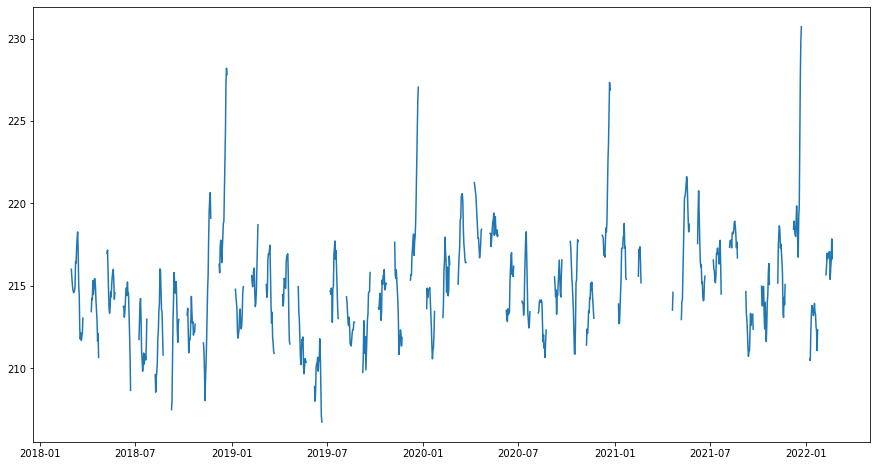

In [140]:
plt.figure(figsize=(15,8))
plt.ion()
#plt.plot(x)
plt.plot(x_filtered)
plt.show()

In [517]:
# Import Data
#df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')
for_plot = df_combined_2

# Prepare data
for_plot['year'] = [d.year for d in for_plot.food_post_date if type(d) is not None]
for_plot['month'] = [d.strftime('%b') for d in for_plot.food_post_date]
years = for_plot['year'].unique()

# Prep Colors
np.random.seed(100)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

# Draw Plot
plt.figure(figsize=(10,10), dpi= 40)
for i, y in enumerate(years):
    if i > 0:        
        plt.plot('month', 'carbohydrates_calories_avg', data=for_plot.loc[for_plot.year==y, :], color=mycolors[i], label=y)
        plt.text(for_plot.loc[for_plot.year==y, :].shape[0]-.9, for_plot.loc[for_plot.year==y, 'carbohydrates_calories_avg'][-1:].values[0], y, fontsize=12, color=mycolors[i])

# Decoration
plt.gca().set(xlim=(-0.3, 11), ylim=(2, 30), ylabel='$Drug Sales$', xlabel='$Month$')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Seasonal Plot of Drug Sales Time Series", fontsize=20)
plt.show()

C:\Users\melik\AppData\Local\Temp\ipykernel_23252\2495417757.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for_plot['year'] = [d.year for d in for_plot.food_post_date if type(d) is not None]
C:\Users\melik\AppData\Local\Temp\ipykernel_23252\2495417757.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for_plot['month'] = [d.strftime('%b') for d in for_plot.food_post_date]


ValueError: Image size of 4461947x1408 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 400x400 with 1 Axes>

In [ ]:
# Import Data
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')
df.reset_index(inplace=True)

# Prepare data
df['year'] = [d.year for d in df.date]
df['month'] = [d.strftime('%b') for d in df.date]
years = df['year'].unique()

# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='value', data=df, ax=axes[0])
sns.boxplot(x='month', y='value', data=df.loc[~df.year.isin([1991, 2008]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()